Run the code by either:
1. selecting `Run all` from the `Cell` dropdown menu above
2. run cell-by-cell, by pressing `Shift + Enter` on your keyboard
  * note; `Alt + Enter` runs a cell and inserts an empty cell below

In [2]:
from typing import Union, List, Any, Optional, Dict

import os
import re
import time
import json
import glob
import pickle
import random
import urllib
import requests
import subprocess
import concurrent.futures

import numpy as np
import pandas as pd
import seaborn as sns

from bs4 import BeautifulSoup
from tqdm import tqdm
from pathlib import Path
from textblob import TextBlob
from threading import current_thread
from matplotlib import pyplot as plt
from collections import Counter
from transformers import BertTokenizer, BertModel
from gap_statistic import OptimalK
from sklearn.cluster import KMeans #, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

from utils import cluster_utils
from utils import cleaning_utils
from utils import IDF_computation
from utils import embedding_utils as embedding
from utils.customdocument import CustomDocument

<div class="alert alert-block alert-info"> 
We will run our term extraction on the Merged Approved Documents, the .pdf file can be found in the `data/` directory. For filtering of out-of-domain terms we will also process a set of EU regulations for medical device design, the .html files for these can be found in the same directory.
</div>

1. Preprocessing will consist only of removing headers/footers from PDF files. 

2. Candidate terms are identified using SPaR.txt (Kruiper et al., 2021), sentence splitting is done with the PunkSentTokenizer (Strunk, 2006).

3. Filtering of term candidates consists of:
  * a set of regular expressions found in utils.py
  * clustering of terms found in (1) the Approved Documents, and (2) a set of EU regulations for medical device design; any clusters containing terms from (2) will be designated as terms that are irrelevant to the AEC domain.
  
 


### 1 Preprocessing: get text from PDF and HTML

<div class="alert alert-block alert-info">
Here, we grab the text from our foreground and background corpora.
</div>


In [3]:
input_path = Path("data/term_extraction_input/")
output_dir = Path("data/converted_documents/")
output_dir.mkdir(parents=True, exist_ok=True) # create the converted_documents directory if needed

# NOTE: in our case the foreground corpus is the merged_approved_pdf_file, 
#       and the background corpus is a set of html files
merged_approved_pdf_file = [x for x in input_path.glob("*.pdf")][0]
eu_html_files = [x for x in input_path.glob("*.html")]

print(f"Approved Documents: {merged_approved_pdf_file}")
print(f"Reference corpus: {[str(x) for x in eu_html_files]}")

Approved Documents: data/term_extraction_input/The Merged Approved Documents.pdf
Reference corpus: ['data/term_extraction_input/EUR-Lex - 31993L0042 - EN.html', 'data/term_extraction_input/CELEX 32017R0746 EN TXT.html', 'data/term_extraction_input/CELEX 32017R0745 EN TXT.html', 'data/term_extraction_input/EUR-Lex - 31998L0079 - EN.html', 'data/term_extraction_input/EUR-Lex - 31990L0385 - EN.html']


In [4]:
merged_approved_pdf_file.exists()

True

<div class="alert alert-block alert-info">
First we grab the text from the Merged Approved Documents pdf file. Our implementation on based on the pdf conversion pipeline in Haystack.
</div>

In [5]:
def read_pdf(file_path: Path, layout: bool = True, encoding: Optional[str] = "Latin1") -> List[str]:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param file_path: path of the pdf file
        :param layout: whether to retain the original physical layout for a page. If disabled, PDF pages are read in
                       the content stream order.
        """
        if layout:
            command = ["pdftotext", "-enc", encoding, "-layout", str(file_path), "-"]
        else:
            command = ["pdftotext", "-enc", encoding, str(file_path), "-"]
        output = subprocess.run(command, stdout=subprocess.PIPE, shell=False)  # type: ignore
        document = output.stdout.decode(errors="ignore")
        pages = document.split("\f")
        pages = pages[:-1]  # the last page in the split is always empty.
        return pages

def convert_pdf_to_mydoc(source_file_path: Path, 
                         output_file_path: Path, 
                         meta: Optional[Dict[str, str]] = None,
                         remove_header_and_footer: Optional[bool] = True,
                         clean_whitespace: Optional[bool] = True,
                         clean_empty_lines: Optional[bool] = True,
                         encoding: Optional[str] = "Latin1") -> CustomDocument:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param output_file_path:    Path to the .json file to store the converted file.
        :param source_file_path:    Path to the .pdf file you want to convert
        :param meta: Optional dictionary with metadata that shall be attached to all resulting documents.
                     Can be any custom keys and values.
        :param encoding: Encoding that will be passed as -enc parameter to pdftotext. "Latin 1" is the default encoding
                         of pdftotext. While this works well on many PDFs, it might be needed to switch to "UTF-8" or
                         others if your doc contains special characters (e.g. German Umlauts, Cyrillic characters ...).
                         Note: With "UTF-8" we experienced cases, where a simple "fi" gets wrongly parsed as
                         "xef\xac\x81c" (see test cases). That's why we keep "Latin 1" as default here.
                         (See list of available encodings by running `pdftotext -listenc` in the terminal)
        """
        pages = read_pdf(source_file_path, layout=True, encoding=encoding)

        if not pages:
            # empty input file
            return None
        
        pages = ["\n".join(p.splitlines()) for p in pages]

        # splitting text happens during preprocessing, so no split_size passed here;
        # split_size will be set to -1 during conversion.
        document = CustomDocument(output_file_path, source_file_path, split_size=-1)
        
        print("Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.")
        for page_idx, page in tqdm(enumerate(pages)):
            
            # some simple cleaning -- roughly based on haystack.
            lines = page.splitlines()
            if remove_header_and_footer:
                # simplest way for removing header and footer 
                lines = lines[1:-2]

            if clean_whitespace:
                cleaned_lines = []
                for line in lines:
                    line = line.strip()
                    cleaned_lines.append(line)
                text = " ".join(cleaned_lines)

            if clean_empty_lines:
                text = re.sub(r"\n\n+", "\n\n", text)
                text = re.sub(r"[\s]+", " ", text)
            
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            page_nr = str(page_idx + 1)
            document.add_content(text=text, 
                                 page_nr=page_nr, 
                                 doc_title=source_file_path.name)   # we're using the pdf file name for simplicity

        return document

In [6]:
output_path = output_dir.joinpath("merged_approved.json")
merged_approved_document = convert_pdf_to_mydoc(merged_approved_pdf_file, output_path)

Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.


1455it [00:00, 5526.47it/s]


In [7]:
print(f"Maximum character length for a single block of text: {max([len(c.text) for c in merged_approved_document.all_contents])}")

Maximum character length for a single block of text: 5349


<div class="alert alert-block alert-info">
Second, we grab the text from the EU regulation HTML files. Because the text in HTML files isn't split into pages, the blocks of text are much longer.
</div>

In [8]:
def grab_HTML_text_simple(file_path: Path):
    """
    All text in the EU htmls seems to be captured neatly in <p> tags, we don't care about structure currently.
    We do remove all unicode characters, see `utils.remove_unicode_chars()`.
    """ 
    with open(file_path, 'r') as f:
        text = f.read()
    soup = BeautifulSoup(text, 'html.parser')
    return [cleaning_utils.remove_unicode_chars(x.text) for x in soup.body.find_all('p')]

In [9]:
def convert_html_to_mydoc(source_file_path: Path, 
                          output_file_path: Path) -> CustomDocument:
    
    document = CustomDocument(output_file_path, source_file_path, split_size=-1)
    document_paragraphs = []
    list_of_paragraphs = grab_HTML_text_simple(source_file_path)
    for paragraph in list_of_paragraphs:
        if paragraph.strip() != '':
            document_paragraphs.append(paragraph)
    
    for paragraph_idx, paragraph in tqdm(enumerate(document_paragraphs)):
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            paragraph_nr = str(paragraph_idx + 1)
            document.add_content(text=paragraph, 
                                 page_nr=paragraph_nr, 
                                 doc_title=source_file_path.name) # we're using the html file name for simplicity
    return document

In [10]:
eu_regulation_documents = []

for html_file in tqdm(eu_html_files):
    output_path = output_dir.joinpath(html_file.stem + ".json")
    eu_regulation_documents.append(convert_html_to_mydoc(html_file, output_path))


  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]
826it [00:00, 257813.30it/s]

4344it [00:00, 346764.68it/s]
 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 2/5 [00:00<00:01,  2.86it/s]
0it [00:00, ?it/s]
4799it [00:00, 33346.53it/s]
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 3/5 [00:01<00:01,  1.75it/s]
623it [00:00, 230062.63it/s]

511it [00:00, 372486.85it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.03it/s]


In [11]:
print(f"Maximum character length for a single paragraph: {max([len(c.text) for d in eu_regulation_documents for c in d.all_contents])}")

Maximum character length for a single paragraph: 143428


<div class="alert alert-block alert-info">
Third, if the output document doesn't exist (yet), we save the ConvertedDocument.
</div>

In [12]:
foreground_corpus = [merged_approved_document]
background_corpus = eu_regulation_documents

In [13]:
for d in foreground_corpus + background_corpus:
    if not os.path.exists(d.output_fp):
        d.write_document()

### 2 Term extraction: identify object spans with SPaR.txt

<div class="alert alert-block alert-info">
For each of the sentences in our corpora, we run SPaR.txt for object identification.
</div>


Note; on a mac, you may have to install the Xcode commandline developer tools. Open a terminal window and run `xcode-select --install` or download Xcode through the App store.



In [14]:
# download SPaR.txt if required
from pathlib import Path
spartxt_path = Path("SPaR.txt/")
if not spartxt_path.exists():
    !git clone https://github.com/rubenkruiper/SPaR.txt.git

In [15]:
import imp
with open(spartxt_path.joinpath('spar_predictor.py'), 'rb') as fp:
    spar_predictor = imp.load_module(
        'spar_predictor', fp, 'SPaR.txt.spar_predictor.py',
        ('.py', 'rb', imp.PY_SOURCE)
    )

/var/folders/lp/l_mzhpjs6bg95plfkl_n_vsc0000gn/T/ipykernel_48058/67904731.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [16]:
# trains a model if needed, otherwise loads from archive; 
# - best F1 on dev/validation in the paper is 80,96 trained on a GPU, CPU will be a bit lower ~77.x I think
sp = spar_predictor.SparPredictor()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# example 
example = "An example sentence to show how ACC terminology will be extracted from the British Standards."
start_time = time.time()
# prepare instance and run model on single instance
docid = ''                  # ToDo - add doc_id during pre_processing?
token_list = sp.predictor._dataset_reader.tokenizer.tokenize(example)
instance = sp.predictor._dataset_reader.text_to_instance(docid,
                                                      example,
                                                      token_list,
                                                      sp.predictor._dataset_reader._token_indexer)
result = sp.predictor.predict_instance(instance)
printable_result = sp.parse_output(result, ['obj'])
print(f"Example input: {example}")
print(printable_result)
print("Parsing took {}".format(time.time() - start_time))

Example input: An example sentence to show how ACC terminology will be extracted from the British Standards.
{'obj': ['An', 'sentence', 'ACC terminology', 'the British Standards']}
Parsing took 0.22223711013793945


* To run SPaR.txt, we split the text in our corpora into sentences. We set up multiple instances of SPaR.txt predictors to speed up the processing a little.

In [18]:
from utils import spar_utils

In [19]:
# We initialize `max_num_cpu_threads` number of SPaR.txt predictors (see spar_utils for details)
# you may want to reduce `max_num_cpu_threads` if the cell below runs into issues
te = spar_utils.TermExtractor(max_num_cpu_threads=4)

In [20]:
# Run SPaR.txt on all documents and write to file
for converted_document in foreground_corpus + background_corpus:
    # re-load the document from file, to make sure we don't overwrite existing SPaR.txt labels
    converted_document = converted_document.load_document(converted_document.output_fp)
    te.process_custom_document(converted_document)
    

Working on: data/term_extraction_input/The Merged Approved Documents.pdf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1455/1455 [00:01<00:00, 1063.72it/s]


Number of sentences found: 20598
Working on: data/term_extraction_input/EUR-Lex - 31993L0042 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 1441.07it/s]


Number of sentences found: 1728
Working on: data/term_extraction_input/CELEX 32017R0746 EN TXT.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4344/4344 [00:01<00:00, 3104.08it/s]


Number of sentences found: 3422
Working on: data/term_extraction_input/CELEX 32017R0745 EN TXT.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4799/4799 [00:01<00:00, 3575.97it/s]


Number of sentences found: 3867
Working on: data/term_extraction_input/EUR-Lex - 31998L0079 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 623/623 [00:00<00:00, 2955.30it/s]


Number of sentences found: 1300
Working on: data/term_extraction_input/EUR-Lex - 31990L0385 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 2981.85it/s]

Number of sentences found: 789


<div class="alert alert-block alert-info">
Number of sentences (longer than 10 characters) found in: <ul>
    <li>Merged Approved documents: 20598</li>
    <li>Background corpus (1728+3422+3867+1300+789): 11106</li>
    </ul>
</div>

### 3 Filtering
<div class="alert alert-block alert-info">
The objects identified by SPaR.txt contain a lot of noise. Here, we clean and filter them; based on our background corpus we try to identify which terms belong to the AEC domain. 
</div>

<div class="alert alert-block alert-info">
First, load all terms from the processed files and apply some basic cleaning.
</div>

In [21]:
regex_filter = cleaning_utils.RegexFilter()
def run_filters(to_be_cleaned):
    # some basic cleaning steps
    _, regex_cleaned  = regex_filter.run_filter(to_be_cleaned) # _ would be the list of terms removed by our regex filters
    basic_cleaned = cleaning_utils.custom_cleaning_rules(regex_cleaned)
    determiners_removed = [cleaning_utils.remove_determiners(t) for t in basic_cleaned]
    cleaned_terms = [t for t in determiners_removed if t]
    cleaned_counter = Counter(cleaned_terms)
    
    # We only want terms to occur at least X times in a corpus, e.g., 3 times:
    cleaned_terms = [t for t in cleaned_terms if cleaned_counter[t] >= 3]
    cleaned_counter = Counter({t: c for t, c in cleaned_counter.items() if c >= 3})
    return cleaned_terms, cleaned_counter

In [22]:
foreground_terms_lists = [c.NER_labels for d in foreground_corpus for c in d.load_document(d.output_fp).all_contents]
foreground_terms_raw = [t for t_list in foreground_terms_lists for t in t_list if t]
print(f"Total number of extracted foreground terms: {len(foreground_terms_raw)}")
print(f"Total unique extracted foreground terms: {len(list(set(foreground_terms_raw)))}")

# cleaning of terms, including removal of determiners
cleaned_foreground_terms, cleaned_foreground_terms_c = run_filters(foreground_terms_raw)
print(f"Total number of cleaned foreground terms: {len(cleaned_foreground_terms)}")
print(f"Total number of UNIQUE foreground terms: {len(cleaned_foreground_terms_c)}")
cleaned_foreground_terms_c.most_common(10)

Total number of extracted foreground terms: 123359
Total unique extracted foreground terms: 43937
Total number of cleaned foreground terms: 72625
Total number of UNIQUE foreground terms: 5584


[('building', 1824),
 ('buildings', 934),
 ('guidance', 887),
 ('requirements', 641),
 ('Building Regulations', 636),
 ('dwelling', 500),
 ('work', 490),
 ('dwellings', 385),
 ('building work', 365),
 ('document', 351)]

In [23]:
background_terms_lists = [c.NER_labels for d in background_corpus for c in d.load_document(d.output_fp).all_contents]
background_terms_raw = [t for t_list in background_terms_lists for t in t_list if t]
print(f"Total number of extracted background terms: {len(background_terms_raw)}")
print(f"Total unique extracted background terms: {len(list(set(background_terms_raw)))}")

# cleaning of terms, including removal of determiners
cleaned_background_terms, cleaned_background_terms_c  = run_filters(background_terms_raw)

print(f"Total number of cleaned background terms: {len(cleaned_background_terms)}")
print(f"Total number of UNIQUE background terms: {len(cleaned_background_terms_c)}")
cleaned_background_terms_c.most_common(10)

Total number of extracted background terms: 72375
Total unique extracted background terms: 10408
Total number of cleaned background terms: 60842
Total number of UNIQUE background terms: 2948


[('device', 1885),
 ('devices', 1696),
 ('manufacturer', 1587),
 ('notified body', 1199),
 ('information', 799),
 ('Member States', 686),
 ('Commission', 652),
 ('requirements', 604),
 ('Regulation', 596),
 ('market', 475)]

In [24]:
print(f"Total number of clean, unique term candidates identified by SPaR.txt:{len(cleaned_foreground_terms_c+cleaned_background_terms_c)}")

Total number of clean, unique term candidates identified by SPaR.txt:7940


<div class="alert alert-block alert-info">
Second, we compute the embeddings for both foreground and background terms.
</div>


* Note: **embeddings** will be IDF weighted (IDF weights over both foreground and background corpora)
  * Could add more sentences to the computation of IDF weights, e.g., definitions from vocabularies/WikiData.

In [25]:
# Which tokenizer to use for IDF computation and Embedding;
bert_model_name = 'bert-base-cased'
embedding_output_fp = Path.cwd().joinpath("data", "term_embedding")
embedding_output_fp.mkdir(parents=True, exist_ok=True) # create the term_embedding directory if needed

In [26]:
# store the cleaned unique_background_spans
with open(Path(embedding_output_fp.joinpath("unique_background_spans.pkl")), 'wb') as f:
    pickle.dump([span for span in cleaned_background_terms_c.keys()], f)

In [27]:
all_terms_c = cleaned_foreground_terms_c + cleaned_background_terms_c

In [28]:
len(all_terms_c)

7940

In [29]:
all_terms_c.most_common(10)

[('device', 1920),
 ('building', 1824),
 ('devices', 1707),
 ('manufacturer', 1669),
 ('requirements', 1245),
 ('notified body', 1202),
 ('information', 1031),
 ('buildings', 934),
 ('guidance', 904),
 ('Member States', 686)]

In [30]:
# identify which terms are MWEs
mwes = []
for t in cleaned_foreground_terms_c.keys():
    words = t.split(' ')
    if len(words) > 1:
        mwes.append(t)

In [31]:
# some insight in number of MWEs to be expected that these still contain a substantial amount of erroneous spans
print("Number of MWEs: {} ({:.2f}%)".format(len(mwes), (len(mwes)/len(cleaned_foreground_terms_c))*100))
random.sample(mwes, 10)

Number of MWEs: 3259 (58.36%)


['fire separation',
 'hot water storage systems',
 'BS 7273',
 'Diagram 9 3',
 'basement storeys',
 'self - contained units',
 'waste disposal',
 'regulation 35',
 'permitted encroachment',
 'wash hand basin']

In [32]:
# Most common MWEs (longer than 1 'word')
mwe_c = Counter({k: v for k, v in cleaned_foreground_terms_c.items() if len(k.split(' ')) > 1})
mwe_c.most_common(10)

[('Building Regulations', 636),
 ('building work', 365),
 ('Schedule 1', 269),
 ('building control body', 193),
 ('Building Regulations 2010', 191),
 ('approved document', 175),
 ('Secretary of State', 175),
 ('parking spaces', 170),
 ('fire resistance', 136),
 ('floor area', 111)]

In [51]:
# Most common examples of MWEs (longer than 3 'words')
mwe_c = Counter({k: v for k, v in cleaned_foreground_terms_c.items() if len(k.split(' ')) > 3})
mwe_c.most_common(10)

[('electric vehicle charge points', 87),
 ('electric vehicle charge point', 51),
 ('with UK National Annex', 43),
 ('on - site electricity generation', 42),
 ('material change of use', 40),
 ('building primary energy rate', 37),
 ('Building Regulations 2010 Approved Docu', 33),
 ('mass per unit area', 30),
 ('Volume 1 : Dwellings', 29),
 ('target primary energy rate', 28)]

In [42]:
# Compute IDF weights
sentence_lists = [c.sentences for d in foreground_corpus + background_corpus for c in d.load_document(d.output_fp).all_contents]
all_sentences = [s for sent_list in sentence_lists for s in sent_list if s]

In [43]:
print(len(all_sentences))
all_sentences[:10]

31704


['The Merged Approved Documents',
 'This document of the Approved Documents includes the 2021 editions of: Approved Document L Volume 1 Conservation of fuel and power Dwellings Approved Document L Volume 2 Conservation of fuel and power Buildings other than dwellings Approved Document F Volume 1 Ventilation Dwellings Approved Document F Volume 2 Ventilation Buildings other than dwellings',
 'Approved Document O Overheatings, and Approved Document S Infrastructure for the charging of electric vehicles These Approved Documents took effect on 15 June 2022, for use in England.',
 'Approved Document L Volume 1 and Volume 2 provides guidance on how to comply with Part L of Schedule 1 to the Building Regulations and in a number of specific building regulations regarding the energy efficiency requirements for dwellings and buildings other than dwellings.',
 'Approved Document F Volume 1 and Volume 2 provides guidance on how to comply with Part F of Schedule 1 to the Building Regulations and in

In [44]:
IDF_path = embedding_output_fp.joinpath("IDF_weights.json")
IDF_c = IDF_computation.IdfComputer(IDF_path, bert_model_name=bert_model_name)
IDF_path = IDF_c.compute_or_load_IDF_weights(all_sentences, overwrite=False)

Loading existing IDF weights.
Printing some IDF values, should be subword units!
['cluster']
['##of']
['deposits']
['ultimate']
['horizontal']
['proximity']
['estates']
['exploration']
['##most']
['rendered']


#### Embed each of the terms identified by SPaR.txt
* TF-IDF weighting and threshold

In [45]:
all_terms = [k for k in all_terms_c.keys()] # counter keys, so already unique
print(f"Number of unique terms: {len(all_terms)}")
all_terms[:10]

Number of unique terms: 7940


['Merged Approved Documents',
 'document',
 'Approved Documents',
 'fuel',
 'dwellings',
 'June 2022',
 'England',
 'Approved',
 'Volume 2',
 'guidance']

In [46]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name, output_hidden_states=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
embedder = embedding.Embedder(tokenizer, bert_model, 
                              IDF_dict=json.load(open(IDF_path)), 
                              embedding_fp=embedding_output_fp,
                              layers_to_use = [12],         # we'll use the output of the last layer
                              layer_combination = "avg",    # how to combine layers if multiple are used
                              idf_threshold = 1.5,          # minimum IDF value for a token to contribute
                              idf_weight_factor = 1.0,      # modify how strong the influence of IDF weighting is
                              not_found_idf_value = 0.5)    # IDF value for tokens that weren't seen during IDF computation (doesn't apply here)

In [48]:
# Compute the embeddings, this is split into subsets so we don't overload your memory (adjust these values if needed)
max_num_cpu_threads = 4
subset_size = 1000

# Checks which of the embeddings for the clustering cluster_data already exist, so they can be re-used
term_subsets = cleaning_utils.split_list(all_terms, subset_size)
embedding_files = [f for f in embedder.embedding_fp.glob('embeddings*.pkl')]
span_and_embedding_pairs = []
if len(embedding_files) == len(term_subsets):
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))
else:
    print(f"Preparing embeddings for {len(all_terms)} spans, in groups of: {subset_size}")
    subset_idx = 0            # iterator index outside of tqdm 
    for subset in tqdm(term_subsets):
        subset_embeddings = []
        subset_file_name = embedder.embedding_fp.joinpath("embeddings_part_{}.pkl".format(subset_idx))
        subset_idx += 1
        if subset_file_name.exists():
            # already computed previously
            continue
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_num_cpu_threads) as executor:
            futures = [executor.submit(embedder.embed_a_span, subset[idx]) for idx in range(len(subset))]

        subset_embeddings += [f.result() for f in futures if f.result()]

        with open(subset_file_name, 'wb') as f:
            pickle.dump(subset_embeddings, f)

    # Once all embeddings are created; combine them in span_and_embedding_pairs
    embedding_files = [f for f in embedder.embedding_fp.glob('embeddings*.pkl')]
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))

In [49]:
# Create a single file with all embeddings, in the meantime standardising the embeddings to improve the representation
unique_spans, unique_embeddings = zip(*span_and_embedding_pairs)
standardised_clustering_data_fp = embedder.embedding_fp.joinpath("standardised_embeddings.pkl")

if not standardised_clustering_data_fp.exists():
    print(f"Normalising and combining computed/existing {len(embedding_files)} embeddings from files into single file")
    with open(embedder.embedding_fp.joinpath("unique_spans.pkl"), 'wb') as f:
        pickle.dump(unique_spans, f)

    with open(embedder.embedding_fp.joinpath("unique_embeddings.pkl"), 'wb') as f:
        # we average over the token embeddings in a term
        unique_clustering_data = np.stack([np.mean(e, axis=0) if len(e.shape) > 1 else e for e in unique_embeddings])

        # standardise the unique clustering data, as suggested by https://github.com/wtimkey/rogue-dimensions
        embedder.emb_mean = unique_clustering_data.mean(axis=0)
        embedder.emb_std = unique_clustering_data.std(axis=0)
        pickle.dump(embedder.emb_mean, open(embedder.embedding_fp.joinpath("standardisation_mean.pkl"), 'wb'))
        pickle.dump(embedder.emb_std, open(embedder.embedding_fp.joinpath("standardisation_std.pkl"), 'wb'))

        standardised_clustering_data = (unique_clustering_data - embedder.emb_mean) / embedder.emb_std

        pickle.dump(standardised_clustering_data, f)

    # Store the standardised embeddings for reuse; could honeslty remove all the other embedding files but will keep them just in case
    pickle.dump(standardised_clustering_data, open(standardised_clustering_data_fp, 'wb'))
    spans_and_standardised_embeddings_dict = dict(zip(unique_spans, standardised_clustering_data))
else:
    standardised_clustering_data = pickle.load(open(standardised_clustering_data_fp, 'rb'))
    spans_and_standardised_embeddings_dict = dict(zip(unique_spans, standardised_clustering_data))
    print(f"Loaded previously computed normalised embedding files.")

Loaded previously computed normalised embedding files.


<div class="alert alert-block alert-info">
Fourth, we determine which terms may be domain-specific. We compare on (1) the number of nearest neighbours of a term that occur in the background corpus, (2) the frequency of terms in each corpus including a simplified version of KL divergence, and (3) a foreground/background TF-IDF for each span.
</div>

In [50]:
# 1 check the kNNs based on the standardised embeddings
n_neighbors = 500 # the number of neighbours we compute for each term
knn_graph = kneighbors_graph(standardised_clustering_data, 
                             n_neighbors,    
                             metric="cosine", 
                             n_jobs=8)

In [51]:
span_df_dict = {}
for span_idx, span in enumerate(unique_spans):
    number_of_background_corpus_neighbours = 0
    for neighbour_idx in knn_graph[span_idx].indices:
        if unique_spans[neighbour_idx] in cleaned_background_terms_c.keys():
            number_of_background_corpus_neighbours += 1
    
    span_df_dict[span] = {'span_idx': span_idx, 
                          'num_background_neighbours': number_of_background_corpus_neighbours,
                          'num_foreground_neighbours': n_neighbors - number_of_background_corpus_neighbours}

In [52]:
# 2 Grab a KL divergence type of notion for each span --> only modified TFIDF 
total_foreground = sum(cleaned_foreground_terms_c.values())
total_background = sum(cleaned_background_terms_c.values())
    

for span in unique_spans:
    foreground_cnt = cleaned_foreground_terms_c[span]
    background_cnt = cleaned_background_terms_c[span]
    
    span_df_dict[span]['foreground_cnt'] = foreground_cnt
    span_df_dict[span]['background_cnt'] = background_cnt
    if (foreground_cnt == 0 and background_cnt == 0):
        print(span)
#     TF_fore_back = foreground_cnt/(foreground_cnt+background_cnt) Adding +1 above to avoid NAN and INF results
    TF_fore_back = np.log(1+(foreground_cnt/(foreground_cnt+background_cnt)))
    
    tokens, indices = embedder.prepare_tokens(span)
    idf_weights = embedder.get_IDF_weights_for_indices(tokens, indices)
    TFIDF_fore_back = TF_fore_back * np.log(np.mean(idf_weights))
    
    span_df_dict[span]['TFIDF_fore_back'] = TFIDF_fore_back
    
    # DEPRECATED; simplified version of KL divergence based on Meyers et al. 2018. 
    # The KLD feature has extreme outliers that occur VERY often in the foreground corpus, and a few times in the background corpus
    # an  example is "guidance" (400+/17), which clearly is a general domain term. So the KLD doesn't necessarily provide the information we want
#     KLD = (np.log(foreground_cnt + 1) - np.log(background_cnt + 1))* (foreground_cnt + 1)
#     span_df_dict[span]['KLD'] = KLD
    
    

In [53]:
# example of a clear AEC domain term
span_df_dict['mortar']

{'span_idx': 2719,
 'num_background_neighbours': 231,
 'num_foreground_neighbours': 269,
 'foreground_cnt': 19,
 'background_cnt': 0,
 'TFIDF_fore_back': 0.8064534127161667}

In [54]:
# example of a clear medical domain term
span_df_dict['patients']

{'span_idx': 5604,
 'num_background_neighbours': 309,
 'num_foreground_neighbours': 191,
 'foreground_cnt': 0,
 'background_cnt': 132,
 'TFIDF_fore_back': 0.0}

In [55]:
# example of a clear general domain term
span_df_dict['test']

{'span_idx': 3305,
 'num_background_neighbours': 326,
 'num_foreground_neighbours': 174,
 'foreground_cnt': 55,
 'background_cnt': 9,
 'TFIDF_fore_back': 0.5606980526467908}

In [56]:
# example of a long AEC domain term
span_df_dict['hot water storage system']

{'span_idx': 4012,
 'num_background_neighbours': 86,
 'num_foreground_neighbours': 414,
 'foreground_cnt': 8,
 'background_cnt': 0,
 'TFIDF_fore_back': 0.8983407716830061}

In [57]:
span_features_df = pd.DataFrame.from_dict(span_df_dict, orient='index')
span_features_df

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
Exist,0,145,355,4,0,0.938284
roof venting,1,11,489,4,0,0.831842
heat release,2,72,428,4,0,0.876470
Each side,3,149,351,4,0,0.882137
Minimum,4,93,407,13,0,0.895564
...,...,...,...,...,...,...
six months,7935,251,249,0,4,0.000000
deadlines,7936,251,249,0,3,0.000000
corrective measures,7937,305,195,0,10,0.000000
Article 104,7938,217,283,0,4,0.000000


In [58]:
print("most FORE-groundy terms according to TF_fore_back:")
span_features_df['TFIDF_fore_back'].nlargest(10)

most FORE-groundy terms according to TF_fore_back:


Volatile Organic Compounds                                  1.300064
Deputy Prime Minister                                       1.270567
urea formaldehyde                                           1.253544
photovoltaic panels                                         1.245708
Orography Factor O                                          1.240135
polystyrene beads                                           1.237285
United Kingdom Accreditation Service                        1.235163
satisfactorily                                              1.232279
Timber Fire Resisting Doorsets : Maintaining Performance    1.225762
volatile organic compound                                   1.222671
Name: TFIDF_fore_back, dtype: float64

In [59]:
print("most BACK-groundy terms according to TF_fore_back:")
span_features_df['TFIDF_fore_back'].nsmallest(10)

most BACK-groundy terms according to TF_fore_back:


unlimited                     -0.126376
Avis juridique important       0.000000
medical devices                0.000000
Treaty                         0.000000
European Economic Community    0.000000
Article 100a                   0.000000
cooperation                    0.000000
Economic Committee             0.000000
internal market                0.000000
internal frontiers             0.000000
Name: TFIDF_fore_back, dtype: float64

In [60]:
from matplotlib.patches import Rectangle

Text(0, 0.5, 'Foreground/Background TFIDF')

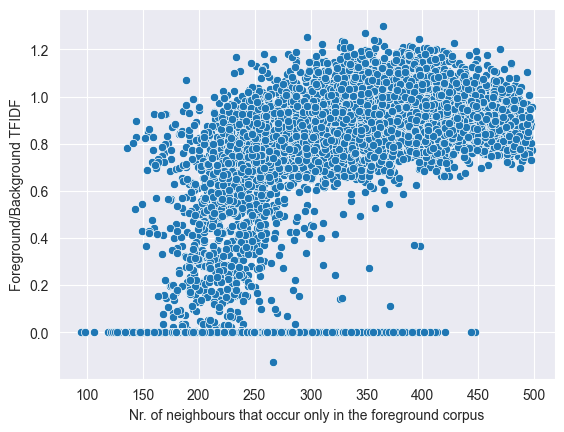

In [61]:
sns.set_style ("darkgrid")
axes = sns.scatterplot(x="num_foreground_neighbours",
                       y="TFIDF_fore_back",
                       data=span_features_df)

axes.set_xlabel("Nr. of neighbours that occur only in the foreground corpus")
axes.set_ylabel("Foreground/Background TFIDF")

This plot shows:
1. the number of foreground neighbours (the rest of the neighbours occur in the background corpus as well)
2. the TF-IDF inspired value for a span, a value of 0 indicating that the term only appears in the background corpus

Our assumption is that at certain combinations of these two values, a term is more likely to be 'domain-specific'. This allows for a crude division into domain vs out-of-domain/general domain terms. For now, we'll assume that general background domain terms have:
* a low TF-IDF value, e.g., smaller than 0.6
* at least half of the NNs being foreground terms, e.g., cut-off at 250/500

In [62]:
min_TFIDF_value = 0.6
min_num_foreground_neighbours = 200

In [63]:
# Example terms VERY TOP LEFT of the plot (expectinggeneral domain)
top = span_features_df['TFIDF_fore_back'] > 1.3 * min_TFIDF_value
left = span_features_df['num_foreground_neighbours'] < 160
span_features_df.loc[top & left]

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
test evidence,257,345,155,15,0,0.848365
test standards,264,364,136,4,0,0.782034
material consideration,815,344,156,6,0,0.862601
standards operation,1418,348,152,3,0,0.825333
integrity performance,2530,356,144,3,0,0.828132
test methods,2910,341,159,18,0,0.826993
certification body,3246,359,141,3,0,0.802906
recommendations report,5068,356,144,3,0,0.897145


In [69]:
# Example terms very TOP RIGHT of the plot (expecting very foreground domainy)
top = span_features_df['TFIDF_fore_back'] > 1.65 * min_TFIDF_value
right = span_features_df['num_foreground_neighbours'] > 480
span_features_df.loc[top & right]

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
timber blocking,1350,16,484,4,0,1.034081
plastic rooflights,2618,19,481,14,0,0.993525
fire - protecting suspended ceilings,2635,17,483,4,0,1.048071
timber tiling,2717,18,482,5,0,1.009156
glazed screens,2815,15,485,12,0,1.006365
rafters,3641,12,488,13,0,1.040589
natural stone cladding,3901,7,493,5,0,1.104269
ventilated discharge stack,4299,16,484,3,0,1.079217
relining flues,4509,14,486,3,0,1.024228
leading edge door,5329,5,495,3,0,1.005022


In [65]:
# Example terms very BOTTOM LEFT of the plot (expecting very background domainy)
bottom = span_features_df['TFIDF_fore_back'] < .1 * min_TFIDF_value
left = span_features_df['num_foreground_neighbours'] < 125
span_features_df.loc[bottom & left]

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
clinical investigations,5704,403,97,0,139,0.0
clinical investigation,5737,405,95,0,220,0.0
evaluation report,6035,380,120,0,8,0.0
testing procedure,6610,376,124,0,6,0.0
clinical application,6657,381,119,0,4,0.0
clinical experience,6687,378,122,0,3,0.0
clinical evaluation,6709,377,123,0,73,0.0
clinical data,7081,394,106,0,61,0.0
clinical evidence,7457,402,98,0,59,0.0


In [70]:
# Example terms BOTTOM RIGHT of the plot (expecting general domain)
bottom = span_features_df['TFIDF_fore_back'] < .1 * min_TFIDF_value
right = span_features_df['num_foreground_neighbours'] > 405
span_features_df.loc[bottom & right]

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
tooth crowns,6759,88,412,0,3,0.0
indents 3 13,6894,87,413,0,4,0.0
Instructions,7040,89,411,0,8,0.0
thermal ignition sources,7079,94,406,0,4,0.0
artificial opening,7228,53,447,0,3,0.0
drilling sawing,7238,57,443,0,3,0.0
retracting,7242,80,420,0,3,0.0
therapeutic window,7480,93,407,0,5,0.0


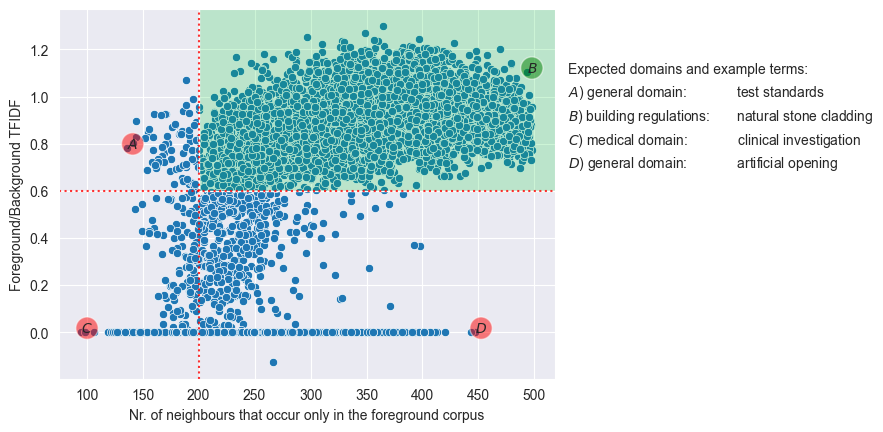

In [67]:
# We'll save the plot as a figure with example terms
fig = plt.figure()
sns.set_style ("darkgrid")
axes = sns.scatterplot(x="num_foreground_neighbours",
                       y="TFIDF_fore_back",
                       data=span_features_df)

axes.set_xlabel("Nr. of neighbours that occur only in the foreground corpus")
axes.set_ylabel("Foreground/Background TFIDF")

axes.axhline(y=min_TFIDF_value, color=(1,0,0,.8), linestyle='dotted')
axes.axvline(x=min_num_foreground_neighbours, color=(1,0,0,.8), linestyle='dotted')

topleft_term = "general domain:\t\t " + "test standards"
topright_term = "building regulations:\t " + "natural stone cladding"
bottomleft_term = "medical domain:\t\t " + "clinical investigation"
bottomright_term = "general domain:\t\t " + "artificial opening"

plt.text(530, 1.1, "Expected domains and example terms:", fontsize = 10)
for idx, term in enumerate([topleft_term, topright_term, bottomleft_term, bottomright_term]):
    x = span_features_df["num_foreground_neighbours"][term.split("\t ")[1]]
    y = span_features_df["TFIDF_fore_back"][term.split("\t ")[1]]
    colour = "green" if (x > min_num_foreground_neighbours and y > min_TFIDF_value) else "red"
    plt.text(x, y, f"${chr(97 + idx).upper()}$", fontsize = 10, bbox = dict(facecolor=colour, 
                                                                            boxstyle='circle',
                                                                            alpha = 0.5))
    plt.text(530, 1 - (.1 * idx), f"${chr(97 + idx).upper()}$) " + term, fontsize = 10)

    
# Create a Rectangle patch
rect = Rectangle((min_num_foreground_neighbours, min_TFIDF_value), 
                 520 - min_num_foreground_neighbours, 
                 1.4 - min_TFIDF_value, facecolor=(0,0.8,0.2,0.2))
# Add the patch to the Axes
axes.add_patch(rect)
fig.savefig(embedding_output_fp.joinpath("plot.jpg"), dpi=300, bbox_inches = "tight") #save as jpg

# we'll also save span_features_df for reuse elsewhere
span_features_df.to_csv(embedding_output_fp.joinpath("span_features.csv"))

* compute domain terms and exemplify

In [101]:
domain_terms = span_features_df[(span_features_df['TFIDF_fore_back'] >= min_TFIDF_value) & (span_features_df['num_foreground_neighbours'] >= min_num_foreground_neighbours)]
ood_terms = span_features_df[(span_features_df['TFIDF_fore_back'] < min_TFIDF_value) | (span_features_df['num_foreground_neighbours'] < min_num_foreground_neighbours)]


In [102]:
# we will store the domain / out-of-domain decision so we can re-use it as a dataset for a kNN voting classifier
domain_term_list = domain_terms.index.tolist()
for term in span_df_dict.keys():
    span_df_dict[term]['domain'] = 'y' if term in domain_term_list else 'n'

with open(embedding_output_fp.joinpath("span_domain_ood_dict.json"), 'w') as f:
    json.dump(span_df_dict, f)  

In [103]:

domain_unique = list(set(domain_terms.index.tolist()))
print(f"Examples of our {len(domain_unique)} AEC domain terms")
random.sample(domain_unique, 10)

Examples of our 4958 AEC domain terms


['cavity masonry core',
 'kilograms per square metre',
 'literature',
 'photocopiers',
 'complex',
 'drain sewer',
 'Appendix B',
 'Sets',
 'Chapter C',
 'accommodation']

In [104]:
print(f"Examples of our {len(ood_terms)} general domain terms")
random.sample(ood_terms.index.tolist(), 10)

Examples of our 2982 general domain terms


['data elements',
 'Annex IV V',
 'arteriae',
 'influence',
 'parameters',
 'acts',
 'standards',
 'Class IIa IIb',
 'Article 65',
 'No 726 / 2004']

* save the domain terms in the folder with inputs for our graph

In [105]:
graph_data_fp = Path("data/graph_data/")
pickle.dump(domain_unique, open(graph_data_fp.joinpath('domain_terms.pkl'), 'wb'))